## MonReader - Part 1

----

### CNN predicting flip or notflip pages

**Objective.**  


**Model.**  

**Method (steps):**

1) 
2) 
3) 
4) 
5) 
   
   


----


#### 0. Imports and Environment

In [1]:
# Core imports
import os, sys, random, json, math
from pathlib import Path
from collections import Counter, defaultdict

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from PIL import Image, ImageOps, ImageStat, UnidentifiedImageError

In [7]:
import torch, torchvision, torchaudio
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("torchaudio:", torchaudio.__version__)
print("built with CUDA:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))


torch: 2.6.0+cu124
torchvision: 0.21.0+cu124
torchaudio: 2.6.0+cu124
built with CUDA: 12.4
cuda available: True
gpu: NVIDIA GeForce GTX 1080 Ti


In [11]:
# reproducibility
SEED = 23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Access the datasets
DATA_ROOT = Path("data") / "images"
splits = ["training", "testing"]
classes = ["flip", "notflip"]

for split in splits:
    for cls in classes:
        p = DATA_ROOT / split / cls
        assert p.is_dir(), f"Missing folder: {p}"
print("Folder structure looks OK.")

Folder structure looks OK.


#### 1. EDA

#### 1.1 Count Images, detect corrupt files, and gather basic metadata

This pass will:
- count files per class,
- catch corrupt/unreadable images,
- record sizes and aspect ratios,
- note any non-RGB modes

In [13]:
def scan_split(split_path: Path):
    """Scan every split. Tracing the Image metadata and add corruptued files into a specific list(corrupt)"""
    rows = []
    corrupt = []
    for cls in classes:
        for f in (split_path/cls).glob("*"):
            if f.is_file():
                try:
                    with Image.open(f) as im:
                        im.load()
                        rows.append({
                            "path": str(f),
                            "split": split_path.name,
                            "label": cls,
                            "w": im.width,
                            "h": im.height,
                            "mode": im.mode,
                            "ratio": im.width / im.height if im.height else np.nan,
                        })
                except (UnidentifiedImageError, OSError) as e:
                    corrupt.append(str(f))
    return rows, corrupt        

In [19]:
all_rows, corrupt_files = [], []
for split in splits:
    rows, bad = scan_split(DATA_ROOT / split)
    all_rows.extend(rows)
    corrupt_files.extend(bad)

In [21]:
print(f"Total images (readable): {len(all_rows)}")
print(f"Corrupt/unreadable: {len(corrupt_files)}")
if corrupt_files:  # files with an Unidentified Image Error when opening
    print("Sample corrupt:", corrupt_files[:5])

Total images (readable): 2989
Corrupt/unreadable: 0


#### 1.2 Class balance and Image size distribution

In [24]:
import pandas as pd

In [25]:
df = pd.DataFrame(all_rows)

In [ ]:
# save the dataframe into a csv file
extraction_table_file = "all_images.csv"
df.to_csv(DATA_ROOT / extraction_table_file)

In [27]:
# class counts
print("\nCounts by split/label:")
print(df.groupby(["split","label"]).size())


Counts by split/label:
split     label  
testing   flip        290
          notflip     307
training  flip       1162
          notflip    1230
dtype: int64


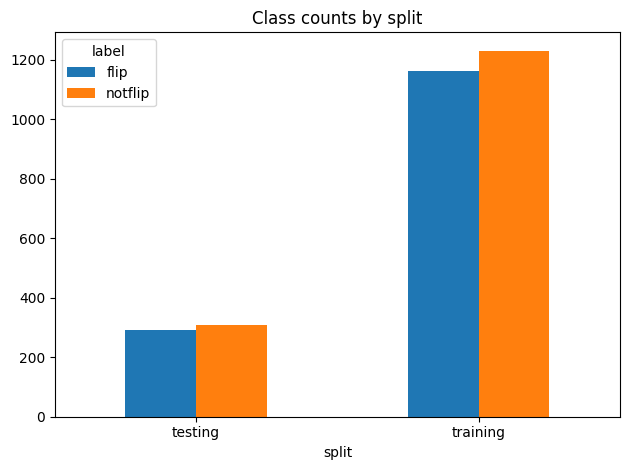

In [34]:
# Class balance bar chart
counts = df.groupby(["split","label"]).size().unstack(fill_value=0)
counts.plot(kind="bar", rot=0, title="Class counts by split")
plt.tight_layout(); plt.show()


We observe: 
- a train/test split of 80 to 20 %
- the classes are balanced in both splits

In [30]:
# overall size stats
print("\nSize stats (W,H) by split:")
print(df.groupby("split")[["w","h"]].describe())


Size stats (W,H) by split:
               w                                                            h  \
           count    mean  std     min     25%     50%     75%     max   count   
split                                                                           
testing    597.0  1080.0  0.0  1080.0  1080.0  1080.0  1080.0  1080.0   597.0   
training  2392.0  1080.0  0.0  1080.0  1080.0  1080.0  1080.0  1080.0  2392.0   

                                                               
            mean  std     min     25%     50%     75%     max  
split                                                          
testing   1920.0  0.0  1920.0  1920.0  1920.0  1920.0  1920.0  
training  1920.0  0.0  1920.0  1920.0  1920.0  1920.0  1920.0  


All the images have the same size: 1080x1920(width-height) no matter the split


#### 1.3 Visual spot-check a few images per class

In [47]:
def show_grid(paths, cols=5, size=3, title=None):
    rows = math.ceil(len(paths)/cols)
    plt.figure(figsize=(cols*size, rows*size))
    for i, p in enumerate(paths):
        with Image.open(p) as im:
            im = ImageOps.exif_transpose(im)  # respect EXIF orientation
            plt.subplot(rows, cols, i+1)
            plt.imshow(im)
            plt.axis("off")
            plt.title(Path(p).parent.name)
    if title: 
        plt.suptitle(title)
    plt.tight_layout()
    plt.show

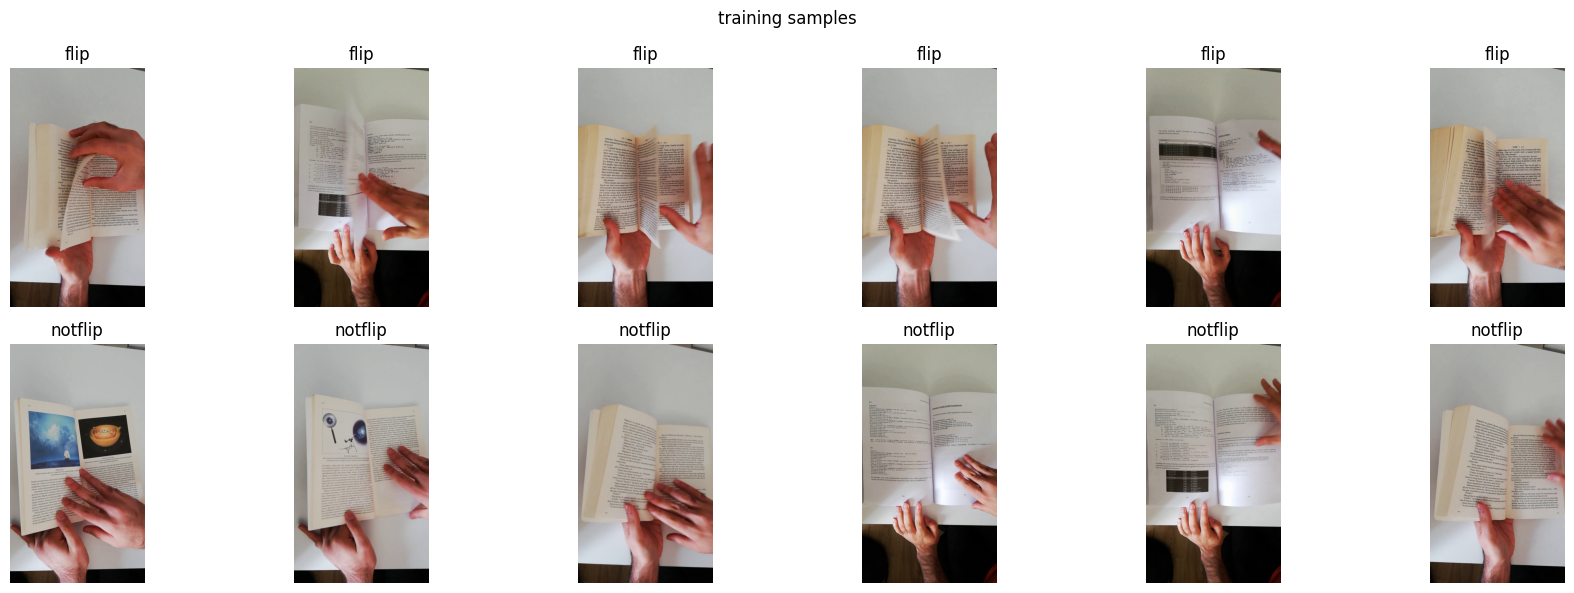

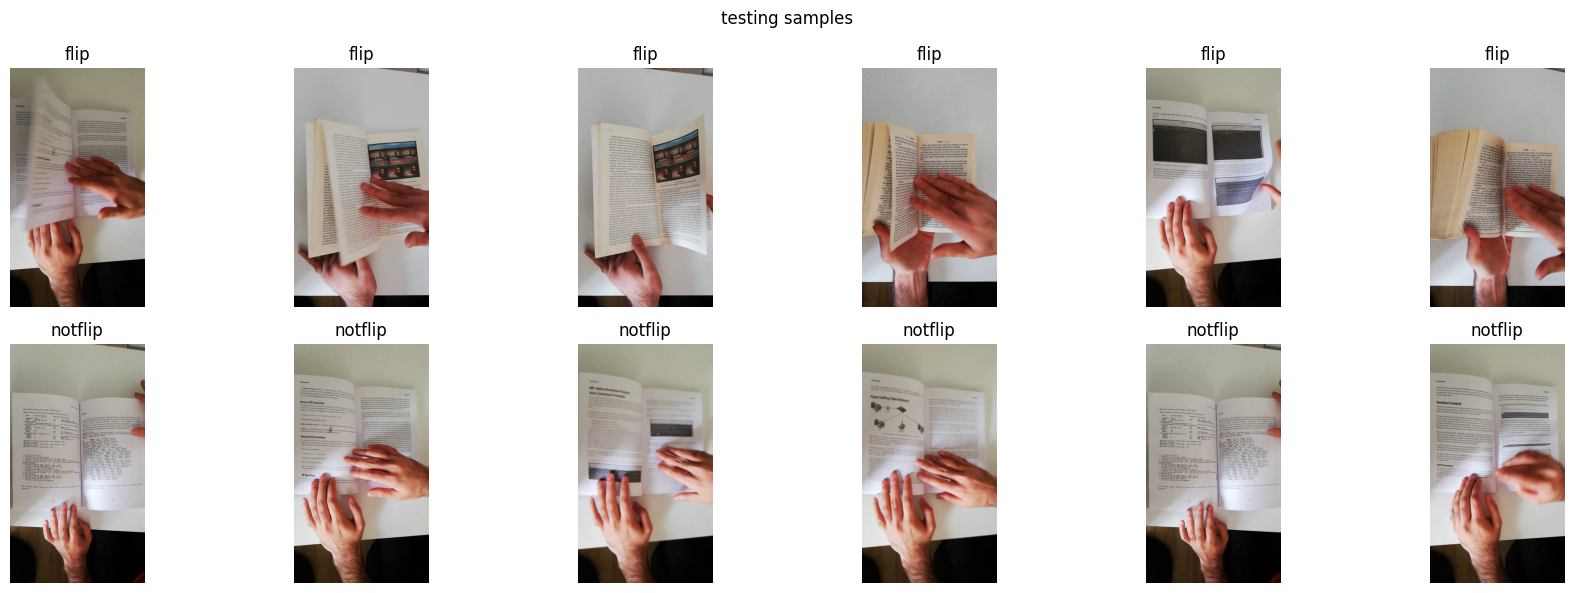

In [50]:
for split in splits:
    grid_paths = []
    for cls in classes:
        cls_paths = list((DATA_ROOT/split/cls).glob("*"))
        random.shuffle(cls_paths)
        grid_paths.extend(cls_paths[:6])
    show_grid(grid_paths, cols=6, title=f"{split} samples")

#### 1.4 Quick brightness & blur stats

In [52]:
import cv2

In [70]:
def image_brightness(im: Image.Image):
    """Calculate the average brightness (luminance) of an image
    using the (ITU-R BT.601 standard): Y=0.299R+0.587G+0.114B"""
    
    # take the mean of Y values, giving the average brightness across the entire image.
    stat = ImageStat.Stat(im.convert("L"))
    # return value form 0 to 255
    return stat.mean[0]  

def laplacian_var(np_img):
    """
    Compute the Laplacian operator to the input image to measure
    local intensity changes (edges), and then computes the variance of the resulting
    Laplacian map (or image). A high variance indicates a sharp image with many strong edges,
    while a low variance suggests a blurred or out-of-focus image.

    Returns: float
    Variance of the Laplacian values. Higher values correspond to sharper images,
    and lower values correspond to blurrier images.
    """
    return cv2.Laplacian(np_img, cv2.CV_64F).var()


In [ ]:
# Calculate the quality stats

# helper function
def _stats(x):
    x = np.asarray(x)
    return {"mean": float(x.mean()), "std": float(x.std(ddof=1)), "n": int(x.size)}

def scan_quality_stats(label: str = "both", sample_n: int = 500, balanced: bool = False):
    """
    Compute brightness/blur per label and pooled across selected labels.

    Parameters
    ----------
    label : {"flip","notflip","both"}
        Subset to analyze. "both" analyzes both labels.
    sample_n : int
        Max samples per selected label. If balanced=True and label="both",
        samples min(sample_n, n_per_class) from EACH class; otherwise samples up to sample_n per class independently.
    balanced : bool
        If True with label="both", enforce equal sample size per class (useful for fair class comparison). Consider that the dataset is almost perfect balanced.

    Returns
    -------
    dict
        {
          "per_label": {
              "flip": {"brightness": {"mean","std","n"}, "blur": {...}},
              "notflip": {...}
          },
          "overall": {
              "brightness": {"mean","std","n"},
              "blur": {"mean","std","n"}
          }
        }
    """
    chosen = ["flip", "notflip"] if label == "both" else [label]
    results = {"per_label": {}, "overall": {}}

    # Collect per-image metrics
    all_brightness, all_blur = [], []
    
    for lab in chosen:
        subset = df[df["label"] == lab]
        take = min(sample_n, len(subset))
        sample = subset.sample(take, random_state=SEED)
        br, bl = [], []
        for p in sample["path"]:
            with Image.open(p) as im:
                im = ImageOps.exif_transpose(im).convert("RGB")
                br.append(image_brightness(im))
                bl.append(laplacian_var(np.array(im)))
        br = np.array(br); bl = np.array(bl)
        results["per_label"][lab] = {
            "brightness": {**_stats(br), "values": br},
            "blur": {**_stats(bl), "values": bl}
        }
        all_brightness.append(br)
        all_blur.append(bl)

    # Overall
    if all_brightness:
        pooled_brightness = np.concatenate(all_brightness)
        pooled_blur = np.concatenate(all_blur)
        results["overall"] = {
            "brightness": {**_stats(pooled_brightness), "values": pooled_brightness},
            "blur": {**_stats(pooled_blur), "values": pooled_blur},
        }

    return results


In [72]:
# Run the Quality Scan
res = scan_quality_stats(label="both", sample_n=500)

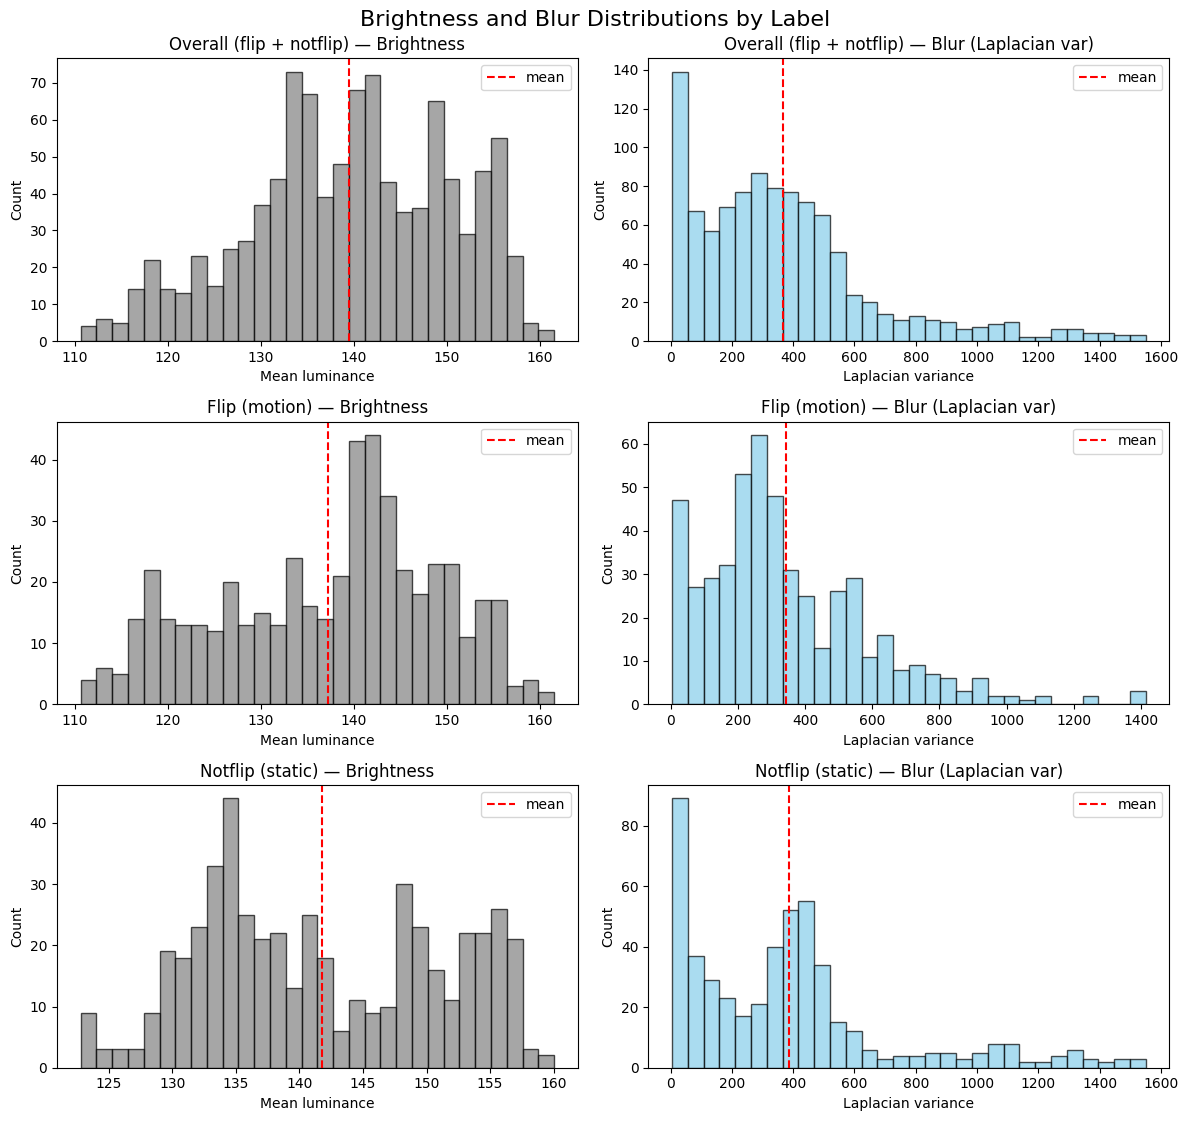

In [73]:
# Prepare figure to plot
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle("Brightness and Blur Distributions by Label", fontsize=16, y=0.93)

labels_order = ["overall", "flip", "notflip"]
titles = ["Overall (flip + notflip)", "Flip (motion)", "Notflip (static)"]

# Helper: build a small accessor so "overall"/labels use the right branch
def _get_block(res, key):
    return res["overall"] if key == "overall" else res["per_label"][key]

for i, lab in enumerate(labels_order):
    # Brightness
    blk = _get_block(res, lab)
    ax_bright = axes[i, 0]
    vals = blk["brightness"]["values"]
    ax_bright.hist(vals, bins=30, color='gray', alpha=0.7, edgecolor='black')
    ax_bright.set_title(f"{titles[i]} — Brightness")
    ax_bright.set_xlabel("Mean luminance")
    ax_bright.set_ylabel("Count")
    ax_bright.axvline(blk["brightness"]["mean"], color='red', linestyle='--', label='mean')
    ax_bright.legend()

    # Blur (Laplacian variance)
    ax_blur = axes[i, 1]
    vals = blk["blur"]["values"]
    ax_blur.hist(vals, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
    ax_blur.set_title(f"{titles[i]} — Blur (Laplacian var)")
    ax_blur.set_xlabel("Laplacian variance")
    ax_blur.set_ylabel("Count")
    ax_blur.axvline(blk["blur"]["mean"], color='red', linestyle='--', label='mean')
    ax_blur.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [82]:
from scipy.stats import mannwhitneyu  # for p-value

In [85]:
# Median and p-value calculations
# flip and notflip arrays
flip_blur = res["per_label"]["flip"]["blur"]["values"]
notflip_blur  = res["per_label"]["notflip"]["blur"]["values"]

# compute medians and p-value
flip_median = np.median(flip_blur)
notflip_median = np.median(notflip_blur)
u_stat, p_val = mannwhitneyu(flip_blur, notflip_blur, alternative='two-sided')

# print with 2-decimal formatting
print(f"Flip blur median: {np.median(flip_blur):.2f}")
print(f"Notflip blur median: {np.median(notflip_blur):.2f}")
u,p = mannwhitneyu(flip_blur, notflip_blur, alternative='two-sided')
print(f"Mann-Whitney U p-value: {p:.2f}")


Flip blur median: 286.79
Notflip blur median: 359.48
Mann-Whitney U p-value: 0.48


#### 1.5 Conclusions

The **analysis of brightness** and blur distributions across both labels reveals that **the dataset is generally well-balanced in exposure**, with no significant differences in brightness between flip (motion) and notflip (static) images. This indicates that lighting conditions are consistent across the two classes, minimizing bias from illumination effects.

Regarding **sharpness**, flip images show slightly lower median Laplacian variance (286.79) compared to notflip images (359.48), which aligns with the expectation that page-flip frames contain more motion blur. However, the Mann–Whitney U test (**p = 0.48**) indicates that this **difference is not statistically significant**, meaning the blur variation between the two classes is weak for direct classification.

In summary, while motion frames are on average somewhat blurrier, blur alone is not a reliable discriminative feature for detecting page flips. The classifier will likely need to learn from additional spatial or contextual cues beyond global sharpness differences.

----

#### 2. Model definition

In [87]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torchvision.transforms.functional as F


In [88]:
# train and test folders
TRAIN_DIR = DATA_ROOT/"train"
TEST_DIR  = DATA_ROOT/"test"

# Target size that respects the 16:9 frames but is lighter than 1080x1920
# Downscaling x2
TARGET_H, TARGET_W = 540, 960   # keep multiples of 32; fits the available GPU
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)


In [89]:
# Aspect-preserving and resize
class ResizePad:
    """Resize preserving aspect ratio, then pad to (TARGET_H, TARGET_W)."""
    def __init__(self, out_h=TARGET_H, out_w=TARGET_W, fill=0):
        self.out_h = out_h
        self.out_w = out_w
        self.fill = fill
                
    def __call__(self, img: Image.Image):
        w, h = img.size
        scale = min(self.out_w / w, self.out_h / h)
        new_w, new_h = int(w * scale), int(h * scale)  
        img = F.resize(img, [new_h, new_w], antialias=True)
        pad_w = self.out_w - new_w  # considering that all the dataset images are 1080x1920, no need of padding!
        pad_h = self.out_h - new_h  # for more general applications we will let these lines of code
        
        # Pad evenly (left, top, right, bottom)
        pad_left  = pad_w // 2
        pad_right = pad_w - pad_left
        pad_top   = pad_h // 2
        pad_bottom= pad_h - pad_top
        img = F.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=self.fill)
        return img


In [ ]:
# Transforms
# Here we define the DataAugmentation transformations that we will apply over the input images
train_tfms = transforms.Compose([
    ResizePad(TARGET_H, TARGET_W, fill=0),
    transforms.RandomRotation(degrees=5, fill=0),
    #transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # mild
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),  # end step: Normalization considering IMAGENET Stats
])

# For the validation set we won't apply DataAugmentation
val_tfms = transforms.Compose([
    ResizePad(TARGET_H, TARGET_W, fill=0),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


**Data Augmentation and Normalization**

In this block we define the preprocessing and augmentation pipeline for the training and validation datasets.  
For training, we apply a few light transformations to slightly vary each image while keeping its original structure:

- **`ResizePad`**: resizes each frame to fit the target resolution while preserving the 16:9 aspect ratio, padding if necessary.  
- **`RandomRotation(degrees=5)`**: simulates small camera tilts or misalignments typical in handheld captures.  
- **`ColorJitter(brightness=0.1, contrast=0.1)`**: introduces mild lighting and contrast variation to improve robustness to illumination changes.  
- **`ToTensor()`**: converts the image to a PyTorch tensor with pixel values scaled to [0, 1].  
- **`Normalize(IMAGENET_MEAN, IMAGENET_STD)`**: standardizes pixel values using ImageNet statistics, matching the normalization used during pretraining.

For the validation set, only resizing, tensor conversion, and normalization are applied—no augmentation—so evaluation reflects the model’s true performance on clean, unaltered data.


In [ ]:
# until here! @$@ 20-10-25 18h39

In [ ]:

# E) Datasets / Dataloaders
train_ds = datasets.ImageFolder(root=str(TRAIN_DIR), transform=train_tfms)
val_ds   = datasets.ImageFolder(root=str(TEST_DIR),  transform=val_tfms)

BATCH_SIZE = 16  # adjust by VRAM; 8–16 should be fine on 1080 Ti with 540x960
NUM_WORKERS = 4

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Classes:", train_ds.classes)
print("Train/Val sizes:", len(train_ds), len(val_ds))
